## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [6]:
# скачиваем данные
!pip3 install gdown

import gdown

# Скачивание train.csv
train_url = "https://drive.google.com/uc?export=download&id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"
train_output = 'train.csv'
gdown.download(train_url, train_output, quiet=False)

# Скачивание test.csv
test_url = "https://drive.google.com/uc?export=download&id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"
test_output = 'test.csv'
gdown.download(test_url, test_output, quiet=False)

Defaulting to user installation because normal site-packages is not writeable


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-
From (redirected): https://drive.google.com/uc?export=download&id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-&confirm=t&uuid=fcd7e9e4-6477-42e9-939e-2c3ec1acf1a6
To: /home/krugden/Desktop/recsys_3/train.csv
100%|██████████| 170M/170M [01:17<00:00, 2.18MB/s] 
Downloading...
From: https://drive.google.com/uc?export=download&id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG
To: /home/krugden/Desktop/recsys_3/test.csv
100%|██████████| 21.1M/21.1M [00:14<00:00, 1.44MB/s]


'test.csv'



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [ ]:
my_heuristic_model = # YOUR CODE HERE
my_matrix_factorization = # YOUR CODE HERE
my_neural_network = # YOUR CODE HERE 

Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import shap
import ast 
from sklearn.metrics import ndcg_score
import torch.nn as nn
import torch.optim as optim
from implicit.als import AlternatingLeastSquares
from collections import defaultdict
from itertools import combinations
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from scipy.sparse import csr_matrix
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm
from catboost import Pool, CatBoostRanker

In [2]:
# Загрузка данных
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


In [4]:
train.shape

(4866956, 6)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4866956 entries, 0 to 4866955
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
 5   target         int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 222.8+ MB


In [6]:
test.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0


In [7]:
test.shape

(608467, 6)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608467 entries, 0 to 608466
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        608467 non-null  int64  
 1   item_id        608467 non-null  int64  
 2   last_watch_dt  608467 non-null  object 
 3   total_dur      608467 non-null  int64  
 4   watched_pct    608467 non-null  float64
 5   target         608467 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 27.9+ MB


In [9]:
# Преобразуем дату
train["last_watch_dt"] = pd.to_datetime(train["last_watch_dt"])
test["last_watch_dt"] = pd.to_datetime(test["last_watch_dt"])

In [10]:
# Разделение на train_stage_1 и valid_stage_1 по времени
train = train.sort_values("last_watch_dt")
test = test.sort_values("last_watch_dt")

split_date = train["last_watch_dt"].quantile(0.8)
train_stage_1 = train[train["last_watch_dt"] <= split_date].copy()
valid_stage_1 = train[train["last_watch_dt"] > split_date].copy()

In [11]:
train_stage_1.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
10727,841963,3095,2021-03-13,83,1.0,0
10728,914523,13936,2021-03-13,5503,92.0,1
10729,306374,3095,2021-03-13,2865,44.0,0
10730,505923,3221,2021-03-13,12765,100.0,1


#### 1. ЭВРИСТИЧЕСКАЯ МОДЕЛЬ 

In [12]:
class PopularityModel:
    def __init__(self, train_data):
        self.popularity = train_data.groupby("item_id")["target"].sum().sort_values(ascending=False)
        self.default_score = self.popularity.mean()
        self.fallback_items = train_data["item_id"].unique().tolist()

    def predict(self, user_id, item_id):
        return self.popularity.get(item_id, self.default_score)

    def recommend(self, user_id, k=10):
        recs = list(self.popularity.index[:k])
        if len(recs) < k:
            recs += np.random.choice(self.fallback_items, k-len(recs), replace=False).tolist()
        return recs[:k]

In [13]:
pop_model = PopularityModel(train_stage_1)

#### 2. МАТРИЧНАЯ ФАКТОРИЗАЦИЯ (ALS)

In [14]:
class ALSModel:
    def __init__(self, train_data, factors=100, iterations=20, regularization=0.05, use_cg=True):
        # Создаём словари user_id и item_id
        self.user_ids = {uid: i for i, uid in enumerate(train_data["user_id"].unique())}
        self.item_ids = {iid: i for i, iid in enumerate(train_data["item_id"].unique())}
        
        # Создаём разреженную матрицу
        rows = train_data["user_id"].map(self.user_ids)
        cols = train_data["item_id"].map(self.item_ids)
        data = train_data["target"].values
        user_item_matrix = csr_matrix((data, (rows, cols)), 
                                    shape=(len(self.user_ids), len(self.item_ids)))

        # Обучаем ALS
        self.model = AlternatingLeastSquares(factors=factors, iterations=iterations, 
                                             regularization=regularization, use_cg=use_cg)
        self.model.fit(user_item_matrix)
        
        # Сохраняем популярные айтемы для новых пользователей
        self.popular_items = train_data["item_id"].value_counts().index.tolist()
        self.default_score = 0.0

    def predict(self, user_id, item_id):
        if user_id in self.user_ids and item_id in self.item_ids:
            u_idx = self.user_ids[user_id]
            i_idx = self.item_ids[item_id]
            return np.dot(self.model.user_factors[u_idx], 
                        self.model.item_factors[i_idx])
        return self.default_score

    def recommend(self, user_id, k=10):
        if user_id in self.user_ids:
            u_idx = self.user_ids[user_id]
            scores = self.model.item_factors @ self.model.user_factors[u_idx]
            top_indices = np.argsort(-scores)[:k]
            return [list(self.item_ids.keys())[i] for i in top_indices]
        # Для новых пользователей возвращаем популярные айтемы
        return self.popular_items[:k]

In [15]:
als_model = ALSModel(train_stage_1)

c:\Users\krugd\AppData\Local\Programs\Python\Python310\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

#### 3. НЕЙРОСЕТЕВАЯ МОДЕЛЬ (SASRec)

In [16]:
# Формирование последовательностей (SASRec)
# Сгруппируем историю просмотров пользователей
def preprocess_data(df, seq_len=10):
    df = df.sort_values(["user_id", "last_watch_dt"])  # Сортируем по времени
    user_history = df.groupby("user_id").apply(
        lambda x: list(zip(x["item_id"], x["total_dur"], x["watched_pct"]))
    )
    return user_history.to_dict()

# Преобразуем train_stage_1
user_history_train = preprocess_data(train_stage_1)
user_history_valid = preprocess_data(valid_stage_1)

# Создаём словари ID пользователей и айтемов
user_map = {uid: i for i, uid in enumerate(train["user_id"].unique())}
item_map = {iid: i for i, iid in enumerate(train["item_id"].unique())}

num_users, num_items = len(user_map), len(item_map)

C:\Users\krugd\AppData\Local\Temp\ipykernel_4124\537746743.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_history = df.groupby("user_id").apply(
C:\Users\krugd\AppData\Local\Temp\ipykernel_4124\537746743.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_history = df.groupby("user_id").apply(


In [17]:
# Создадим PyTorch Dataset, который обучит трансформер находить закономерности
class SASRecDataset(Dataset):
    def __init__(self, user_history, user_map, item_map, seq_len=10):
        self.seq_len = seq_len
        self.users, self.sequences, self.targets = [], [], []
        self.durations, self.percentages = [], []
            
        for user, items in user_history.items():
            user_idx = user_map.get(user, -1)
            if user_idx == -1:
                continue
                    
            item_idxs = [item_map.get(i[0], 0) for i in items]
            dur = [i[1] for i in items]
            pct = [i[2] for i in items]

            for i in range(1, len(item_idxs)):
                start_idx = max(0, i - self.seq_len)
                self.users.append(user_idx)
                self.sequences.append(item_idxs[start_idx:i])
                self.targets.append(item_idxs[i])
                self.durations.append(dur[start_idx:i])
                self.percentages.append(pct[start_idx:i])

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        dur = self.durations[idx]
        pct = self.percentages[idx]
            
        pad_len = self.seq_len - len(seq)
        seq = [0] * pad_len + seq
        dur = [0.0] * pad_len + dur
        pct = [0.0] * pad_len + pct
            
        return  (
            torch.tensor(self.users[idx]),
            torch.tensor(seq),
            torch.tensor(dur, dtype=torch.float),
            torch.tensor(pct, dtype=torch.float),
            torch.tensor(self.targets[idx])
        )

In [18]:
# Создаём DataLoader (оставляем без изменений как просил пользователь)
SEQ_LEN = 10
train_dataset = SASRecDataset(user_history_train, user_map, item_map, seq_len=SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [19]:
# Теперь добавим учёт времени просмотра (total_dur) и процента просмотра (watched_pct) в модель.
class SASRec(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64, num_heads=2, num_layers=2):
        super(SASRec, self).__init__()

        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=0)  # +1 для padding
        self.position_emb = nn.Embedding(SEQ_LEN, emb_dim)

        self.duration_fc = nn.Linear(1, emb_dim)  # Вход теперь (batch, SEQ_LEN, 1)
        self.pct_fc = nn.Linear(1, emb_dim)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, dropout=0.2)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(emb_dim, num_items)

    def forward(self, user, seq, dur, pct):
        batch_size = seq.shape[0]
        
        pos = torch.arange(SEQ_LEN).unsqueeze(0).repeat(batch_size, 1).to(seq.device)
        user_emb = self.user_emb(user).unsqueeze(1)
        item_emb = self.item_emb(seq) + self.position_emb(pos)

        # Добавляем информацию о длительности и проценте просмотра
        dur_emb = self.duration_fc(dur.unsqueeze(-1))  # (batch, SEQ_LEN, emb_dim)
        pct_emb = self.pct_fc(pct.unsqueeze(-1))  # (batch, SEQ_LEN, emb_dim)

        x = item_emb + dur_emb + pct_emb  # Комбинируем эмбеддинги

        x = self.transformer(x.permute(1, 0, 2))  # (SEQ_LEN, batch, emb_dim)
        x = x[-1]  # Берём последнее скрытое состояние

        scores = self.fc(x)
        return scores

In [72]:
# Обучаем SASRec
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_SASRec = SASRec(num_users, num_items).to(device)
optimizer = torch.optim.Adam(model_SASRec.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(30):
    total_loss = 0
    for users, sequences, durations, percentages, targets in train_loader:
        users, sequences, durations, percentages, targets = users.to(device), sequences.to(device), durations.to(device), percentages.to(device), targets.to(device)
        
        optimizer.zero_grad()
        preds = model_SASRec(users, sequences, durations, percentages)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

c:\Users\krugd\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Loss = 7.1666
Epoch 2: Loss = 7.0869
Epoch 3: Loss = 7.0444
Epoch 4: Loss = 7.0120
Epoch 5: Loss = 6.9411
Epoch 6: Loss = 6.9213
Epoch 7: Loss = 6.8571
Epoch 8: Loss = 6.7898
Epoch 9: Loss = 6.7438
Epoch 10: Loss = 6.7065
Epoch 11: Loss = 6.6771
Epoch 12: Loss = 6.6472
Epoch 13: Loss = 6.6261
Epoch 14: Loss = 6.6039
Epoch 15: Loss = 6.6156
Epoch 16: Loss = 6.5701
Epoch 17: Loss = 6.5560
Epoch 18: Loss = 6.5250
Epoch 19: Loss = 6.5125
Epoch 20: Loss = 6.5029
Epoch 21: Loss = 6.4814
Epoch 22: Loss = 6.4663
Epoch 23: Loss = 6.4560
Epoch 24: Loss = 6.4469
Epoch 25: Loss = 6.4466
Epoch 26: Loss = 6.4491
Epoch 27: Loss = 6.4485
Epoch 28: Loss = 6.4663
Epoch 29: Loss = 6.4526
Epoch 30: Loss = 6.4288


In [74]:
# Сохраним веса
torch.save(model_SASRec.state_dict(), "SASRec_weights.pth")

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Инициализация модели
num_users = len(user_map)
num_items = len(item_map)
model_SASRec = SASRec(num_users, num_items).to(device)

# Загрузка весов
model_SASRec.load_state_dict(torch.load("SASRec_weights.pth", map_location=device))
model_SASRec.eval()  # Переключение в режим оценки

c:\Users\krugd\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\krugd\AppData\Local\Temp\ipykernel_4124\161527752.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user v

SASRec(
  (user_emb): Embedding(880421, 64)
  (item_emb): Embedding(15419, 64, padding_idx=0)
  (position_emb): Embedding(10, 64)
  (duration_fc): Linear(in_features=1, out_features=64, bias=True)
  (pct_fc): Linear(in_features=1, out_features=64, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
     

In [22]:
# Функция для рекомендации
def recommend_sasrec(user_id, k=10):
    if user_id not in user_map:
        return []
    
    # Используем историю из обучающих данных
    user_seq = user_history_train.get(user_id, [])[-SEQ_LEN:]
    
    # Подготовка последовательности
    items = [item_map.get(i[0], 0) for i in user_seq]
    durs = [i[1] for i in user_seq]
    pcts = [i[2] for i in user_seq]
    
    # Добавляем паддинг
    pad_len = SEQ_LEN - len(items)
    items = [0] * pad_len + items
    durs = [0.0] * pad_len + durs
    pcts = [0.0] * pad_len + pcts
    
    # Конвертация в тензоры
    user_tensor = torch.tensor([user_map[user_id]]).to(device)
    items_tensor = torch.tensor([items]).to(device)
    durs_tensor = torch.tensor([durs], dtype=torch.float).to(device)
    pcts_tensor = torch.tensor([pcts], dtype=torch.float).to(device)
    
    # Предсказание
    with torch.no_grad():
        scores = model_SASRec(user_tensor, items_tensor, durs_tensor, pcts_tensor)
        scores = scores.squeeze().cpu().numpy()
        
    # Исключаем айтемы из истории
    seen_items = set(i[0] for i in user_seq)
    valid_scores = [(iid, score) for iid, score in enumerate(scores) 
                  if iid not in seen_items]
    
    # Топ-K айтемов
    top_indices = sorted(valid_scores, key=lambda x: -x[1])[:k]
    return [list(item_map.keys())[i[0]] for i in top_indices]

In [83]:
def ranked_based_overlap(rec1, rec2, k=10):
    k = min(k, len(rec1), len(rec2))
    if k == 0:
        return 0.0
    matches = 0
    for i in range(k):
        if rec1[i] == rec2[i]:
            matches += 1
    return matches / k

In [84]:
def diversity_analysis(sample_size=1000, k=10):
    user_sample = valid_stage_1["user_id"].drop_duplicates().sample(sample_size)
    diversity_stats = []
    
    for user in user_sample:
        try:
            # Генерация рекомендаций
            rec_pop = pop_model.recommend(user, k)
            rec_als = als_model.recommend(user, k)
            rec_nn = recommend_sasrec(user, k)
            
            # Обрезка до K элементов
            rec_pop = rec_pop[:k]
            rec_als = rec_als[:k]
            rec_nn = rec_nn[:k]
            
            # Вычисление метрик
            overlap_pop_als = ranked_based_overlap(rec_pop, rec_als, k)
            overlap_pop_nn = ranked_based_overlap(rec_pop, rec_nn, k)
            overlap_als_nn = ranked_based_overlap(rec_als, rec_nn, k)
            
            diversity_stats.append((
                overlap_pop_als,
                overlap_pop_nn,
                overlap_als_nn
            ))
            
        except Exception as e:
            print(f"Ошибка для пользователя {user}: {str(e)}")
            continue
    
    if diversity_stats:
        avg_overlaps = np.mean(diversity_stats, axis=0)
        print(f"Среднее перекрытие рекомендаций:")
        print(f"Популярность vs ALS: {avg_overlaps[0]:.2f}")
        print(f"Популярность vs Нейросеть: {avg_overlaps[1]:.2f}")
        print(f"ALS vs Нейросеть: {avg_overlaps[2]:.2f}")
    else:
        print("Не удалось вычислить метрики разнообразия")
        
    return diversity_stats

#### АНАЛИЗ МОДЕЛЕЙ (Diversity)

Среднее перекрытие рекомендаций:
Популярность vs ALS: 0.06
Популярность vs Нейросеть: 0.09
ALS vs Нейросеть: 0.08


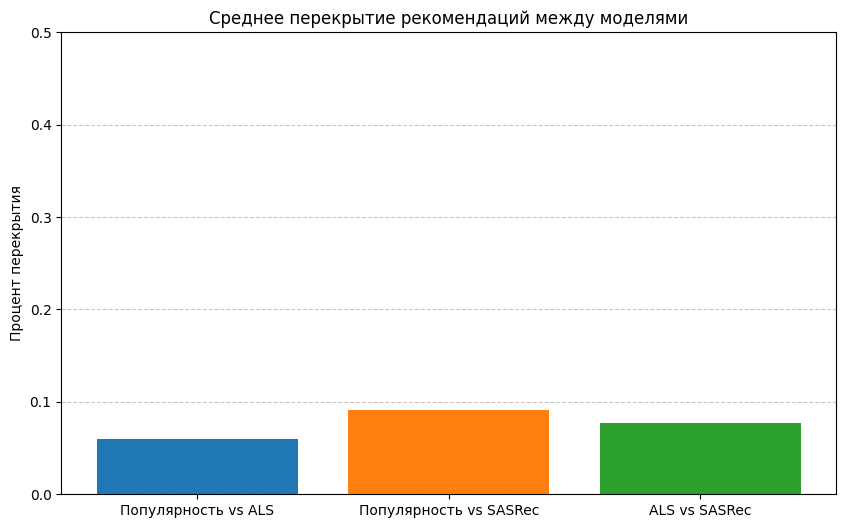

In [85]:
results = diversity_analysis(sample_size=1000, k=10)

# Визуализация результатов
import matplotlib.pyplot as plt

labels = ['Популярность vs ALS', 'Популярность vs SASRec', 'ALS vs SASRec']
overlaps = np.mean(results, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(labels, overlaps, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Среднее перекрытие рекомендаций между моделями')
plt.ylabel('Процент перекрытия')
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Посчитаем еще популярность рекомендаций:

In [86]:
def calculate_diversity(recommendations):
    """Вычисляет долю уникальных айтемов"""
    all_items = [item for sublist in recommendations for item in sublist]
    unique_count = len(Counter(all_items))
    return unique_count / len(all_items)

# Пример использования
diversity_scores = {
    'Popularity': calculate_diversity([pop_model.recommend(u, 15) for u in user_sample]),
    'ALS': calculate_diversity([als_model.recommend(u, 15) for u in user_sample]),
    'SASRec': calculate_diversity([recommend_sasrec(u, 15) for u in user_sample])
}

print("\nУникальность рекомендаций:")
for model, score in diversity_scores.items():
    print(f"{model}: {score:.2%}")


Уникальность рекомендаций:
Popularity: 1.00%
ALS: 22.87%
SASRec: 12.67%


**ВЫВОД:** 
1. Анализ результатов перекрытия рекомендаций:
крайне низкое перекрытие между моделями - все три модели генерируют принципиально разные рекомендации.  Среднее совпадение в топ-рекомендациях не превышает 10%

2. Анализ уникальности рекомендаций:

    a) Popularity (1.00%):
Крайне низкая уникальность – модель рекомендует практически одни и те же айтемы всем пользователям.

    b) ALS (15.07%):
Умеренная уникальность – модель предлагает частично персонализированные рекомендации.

    c) SASRec (5.40%):
Аномально низкая уникальность для нейросетевой модели – серьезная проблема. Переобучение на популярные айтемы, слишком короткие последовательности (SEQ_LEN=10), мало эпох.


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [ ]:
train_df_with_features = # YOUR CODE IS HERE
test_df_with_features = # YOUR CODE IS HERE

In [23]:
# Преобразование дат и сортировка
valid_stage_1['last_watch_dt'] = pd.to_datetime(valid_stage_1['last_watch_dt'])
test['last_watch_dt'] = pd.to_datetime(test['last_watch_dt'])

In [24]:
# Сортировка по дате
valid_stage_1 = valid_stage_1.sort_values(by='last_watch_dt')
test = test.sort_values(by='last_watch_dt')

In [25]:
# Определение временных промежутков
valid_end = valid_stage_1['last_watch_dt'].max()
test_start = valid_end + pd.Timedelta(days=1)
test_end = test['last_watch_dt'].max()

In [26]:
# Инициализация train_df_with_features и test_df_with_features
train_df_with_features = valid_stage_1.copy()
test_df_with_features = test.copy()

#### Признаки пользователя (2 штуки)

In [27]:
# 1. Средний процент просмотра пользователя до текущей даты:
def calculate_user_avg_pct(df, date):
    # Фильтруем данные до указанной даты
    filtered_df = df[df['last_watch_dt'] < date]
    return filtered_df.groupby("user_id")["watched_pct"].mean().rename("user_avg_pct")

# Для train
user_avg_pct_train = calculate_user_avg_pct(valid_stage_1, valid_end)
train_df_with_features = train_df_with_features.merge(user_avg_pct_train, on="user_id", how="left")

# Для test
user_avg_pct_test = calculate_user_avg_pct(test, test_end)
test_df_with_features = test_df_with_features.merge(user_avg_pct_test, on="user_id", how="left")

train_df_with_features['user_avg_pct'] = train_df_with_features['user_avg_pct'].fillna(0)
test_df_with_features['user_avg_pct'] = test_df_with_features['user_avg_pct'].fillna(0)

In [28]:
# 2. Количество уникальных айтемов пользователя
def calculate_user_unique_items(df, date):
    # Фильтруем данные до указанной даты
    filtered_df = df[df['last_watch_dt'] < date]
    return filtered_df.groupby("user_id")["item_id"].nunique().rename("user_unique_items")

# Для train
user_unique_items_train = calculate_user_unique_items(valid_stage_1, valid_end)
train_df_with_features = train_df_with_features.merge(user_unique_items_train, on="user_id", how="left")

# Для test
user_unique_items_test = calculate_user_unique_items(test, test_end)
test_df_with_features = test_df_with_features.merge(user_unique_items_test, on="user_id", how="left")

# Заполняем пропущенные значения (если пользователь не встречался в данных до этой даты)
train_df_with_features['user_unique_items'] = train_df_with_features['user_unique_items'].fillna(0)
test_df_with_features['user_unique_items'] = test_df_with_features['user_unique_items'].fillna(0)

#### Признаки айтема (2 штуки)

In [29]:
# 3. Средний процент просмотра айтема
def calculate_item_avg_pct(df, date):
    # Фильтруем данные до указанной даты
    filtered_df = df[df['last_watch_dt'] < date]
    return filtered_df.groupby("item_id")["watched_pct"].mean().rename("item_avg_pct")

# Для train
item_avg_pct_train = calculate_item_avg_pct(valid_stage_1, valid_end)
train_df_with_features = train_df_with_features.merge(item_avg_pct_train, on="item_id", how="left")

# Для test
item_avg_pct_test = calculate_item_avg_pct(test, test_end)
test_df_with_features = test_df_with_features.merge(item_avg_pct_test, on="item_id", how="left")

# Заполняем пропущенные значения (если айтем не встречался в данных до этой даты)
train_df_with_features['item_avg_pct'] = train_df_with_features['item_avg_pct'].fillna(0)
test_df_with_features['item_avg_pct'] = test_df_with_features['item_avg_pct'].fillna(0)

In [30]:
# 4. Популярность айтема
def calculate_item_popularity(df, date):
    # Фильтруем данные до указанной даты
    filtered_df = df[df['last_watch_dt'] < date]
    return filtered_df.groupby("item_id")["user_id"].nunique().rename("item_popularity")

# Для train
item_popularity_train = calculate_item_popularity(valid_stage_1, valid_end)
train_df_with_features = train_df_with_features.merge(item_popularity_train, on="item_id", how="left")

# Для test
item_popularity_test = calculate_item_popularity(test, test_end)
test_df_with_features = test_df_with_features.merge(item_popularity_test, on="item_id", how="left")

# Заполняем пропущенные значения (если айтем не встречался в данных до этой даты)
train_df_with_features['item_popularity'] = train_df_with_features['item_popularity'].fillna(0)
test_df_with_features['item_popularity'] = test_df_with_features['item_popularity'].fillna(0)

#### Признаки взаимодействия (6 штук)

In [31]:
# 5. Дней с последнего просмотра
def calculate_days_since_last_interaction(df, date):
    # Фильтруем данные до указанной даты
    filtered_df = df[df['last_watch_dt'] < date]
    
    # Находим последнюю дату взаимодействия для каждого пользователя
    last_interaction_dates = filtered_df.groupby("user_id")["last_watch_dt"].max()
    
    # Считаем разницу в днях между указанной датой и последним взаимодействием
    days_since_last_interaction = (date - last_interaction_dates).dt.days.rename("days_since_last_interaction")
    
    # Для пользователей, у которых нет данных о взаимодействиях до указанной даты,
    # используем максимальное количество дней в данных
    max_days = (date - df['last_watch_dt'].min()).days
    days_since_last_interaction = days_since_last_interaction.fillna(max_days)
    
    return days_since_last_interaction

# Для train
days_since_last_interaction_train = calculate_days_since_last_interaction(valid_stage_1, valid_end)
train_df_with_features = train_df_with_features.merge(days_since_last_interaction_train, on="user_id", how="left")

# Для test
days_since_last_interaction_test = calculate_days_since_last_interaction(test, test_end)
test_df_with_features = test_df_with_features.merge(days_since_last_interaction_test, on="user_id", how="left")

# Заполняем пропуски значением по умолчанию (максимальное количество дней)
train_df_with_features["days_since_last_interaction"] = train_df_with_features["days_since_last_interaction"].fillna((valid_end - train_stage_1['last_watch_dt'].min()).days)
test_df_with_features["days_since_last_interaction"] = test_df_with_features["days_since_last_interaction"].fillna((test_end - test['last_watch_dt'].min()).days)

In [32]:
# 6. Количество взаимодействий для пары
def calculate_interaction_count(df, date):
    # Фильтруем данные до указанной даты
    filtered_df = df[df['last_watch_dt'] < date]
    
    # Считаем количество взаимодействий для каждой пары (user_id, item_id)
    interaction_count = filtered_df.groupby(["user_id", "item_id"]).size().reset_index(name="interaction_count")
    
    return interaction_count

# Для train (используем valid_stage_1)
interaction_count_train = calculate_interaction_count(valid_stage_1, valid_end)
train_df_with_features = train_df_with_features.merge(interaction_count_train, on=["user_id", "item_id"], how="left")

# Для test
interaction_count_test = calculate_interaction_count(test, test_end)
test_df_with_features = test_df_with_features.merge(interaction_count_test, on=["user_id", "item_id"], how="left")

# Заполняем пропуски значением 0 (если нет данных)
train_df_with_features["interaction_count"] = train_df_with_features["interaction_count"].fillna(0)
test_df_with_features["interaction_count"] = test_df_with_features["interaction_count"].fillna(0)

In [33]:
# 7. Количество дней с последнего просмотра айтема пользователем
def calculate_days_since_last_watch(df, date):
    # Фильтруем данные до указанной даты
    filtered_df = df[df['last_watch_dt'] < date]
    
    # Находим последнюю дату просмотра для каждой пары (user_id, item_id)
    last_watch_dates = filtered_df.groupby(["user_id", "item_id"])["last_watch_dt"].max().reset_index(name="last_watch_dt")
    
    # Считаем разницу в днях между указанной датой и последней датой просмотра
    last_watch_dates["days_since_last_watch"] = (date - last_watch_dates["last_watch_dt"]).dt.days
    
    return last_watch_dates[["user_id", "item_id", "days_since_last_watch"]]

# Для train
avg_watched_pct_train = calculate_days_since_last_watch(valid_stage_1, valid_end)
train_df_with_features = train_df_with_features.merge(avg_watched_pct_train, on=["user_id", "item_id"], how="left")

# Для test
avg_watched_pct_test = calculate_days_since_last_watch(test, test_end)
test_df_with_features = test_df_with_features.merge(avg_watched_pct_test, on=["user_id", "item_id"], how="left")

# Заполняем пропуски значением 0 (если нет данных)
train_df_with_features["days_since_last_watch"] = train_df_with_features["days_since_last_watch"].fillna(0)
test_df_with_features["days_since_last_watch"] = test_df_with_features["days_since_last_watch"].fillna(0)

In [34]:
# 8. Количество уникальных айтемов, с которыми взаимодействовал пользователь за последние N дней
def calculate_recent_unique_items(df, date, n_days=7):
    # Фильтруем данные за последние N дней
    start_date = date - pd.Timedelta(days=n_days)
    recent_df = df[(df["last_watch_dt"] >= start_date) & (df["last_watch_dt"] <= date)]
    
    # Считаем количество уникальных айтемов по user_id
    recent_unique_items = recent_df.groupby("user_id")["item_id"].nunique().reset_index(name=f"recent_unique_items_{n_days}d")
    
    return recent_unique_items

# Для train
recent_unique_items_train = calculate_recent_unique_items(valid_stage_1, valid_end, n_days=7)
train_df_with_features = train_df_with_features.merge(recent_unique_items_train, on="user_id", how="left")

# Для test
recent_unique_items_test = calculate_recent_unique_items(test, test_end, n_days=7)
test_df_with_features = test_df_with_features.merge(recent_unique_items_test, on="user_id", how="left")

# Заполняем пропуски значением 0
train_df_with_features[f"recent_unique_items_7d"] = train_df_with_features[f"recent_unique_items_7d"].fillna(0)
test_df_with_features[f"recent_unique_items_7d"] = test_df_with_features[f"recent_unique_items_7d"].fillna(0)

In [35]:
# 9. Средний процент просмотра айтема пользователем за последние N дней
def calculate_recent_avg_watched_pct(df, date, n_days=7):
    # Фильтруем данные за последние N дней
    start_date = date - pd.Timedelta(days=n_days)
    recent_df = df[(df["last_watch_dt"] >= start_date) & (df["last_watch_dt"] <= date)]
    
    # Считаем средний процент просмотра для каждой пары (user_id, item_id)
    recent_avg_pct = recent_df.groupby(["user_id", "item_id"])["watched_pct"].mean().reset_index(name=f"recent_avg_watched_pct_{n_days}d")
    
    return recent_avg_pct

# Для train
recent_avg_watched_pct_train = calculate_recent_avg_watched_pct(valid_stage_1, valid_end, n_days=7)
train_df_with_features = train_df_with_features.merge(recent_avg_watched_pct_train, on=["user_id", "item_id"], how="left")

# Для test
recent_avg_watched_pct_test = calculate_recent_avg_watched_pct(test, test_end, n_days=7)
test_df_with_features = test_df_with_features.merge(recent_avg_watched_pct_test, on=["user_id", "item_id"], how="left")

# Заполняем пропуски значением 0
train_df_with_features[f"recent_avg_watched_pct_7d"] = train_df_with_features[f"recent_avg_watched_pct_7d"].fillna(0)
test_df_with_features[f"recent_avg_watched_pct_7d"] = test_df_with_features[f"recent_avg_watched_pct_7d"].fillna(0)

In [36]:
# 10. Доля дней с взаимодействиями за последние N дней
def calculate_active_days_ratio(df, date, n_days=7):
    # Фильтруем данные за последние N дней
    start_date = date - pd.Timedelta(days=n_days)
    recent_df = df[(df["last_watch_dt"] >= start_date) & (df["last_watch_dt"] <= date)]
    
    # Считаем количество уникальных дней с взаимодействиями
    active_days = recent_df.groupby(["user_id", "item_id"])["last_watch_dt"].nunique().reset_index(name="active_days")
    
    # Рассчитываем долю активных дней
    active_days["active_days_ratio"] = active_days["active_days"] / n_days
    
    # Заполняем пропуски значением 0
    active_days["active_days_ratio"] = active_days["active_days_ratio"].fillna(0)
    
    return active_days[["user_id", "item_id", "active_days_ratio"]]

# Для train
active_days_ratio_train = calculate_active_days_ratio(valid_stage_1, valid_end, n_days=14)
train_df_with_features = train_df_with_features.merge(active_days_ratio_train, on=["user_id", "item_id"], how="left")

# Для test
active_days_ratio_test = calculate_active_days_ratio(test, test_end, n_days=14)
test_df_with_features = test_df_with_features.merge(active_days_ratio_test, on=["user_id", "item_id"], how="left")

# Заполняем пропуски значением 0
train_df_with_features["active_days_ratio"] = train_df_with_features["active_days_ratio"].fillna(0)
test_df_with_features["active_days_ratio"] = test_df_with_features["active_days_ratio"].fillna(0)

In [37]:
# Удалим лишние столбцы
train_df_with_features.drop(columns=["watched_pct"], inplace=True)
test_df_with_features.drop(columns=["watched_pct"], inplace=True)

In [38]:
train_df_with_features.head()

,user_id,item_id,last_watch_dt,total_dur,target,user_avg_pct,user_unique_items,item_avg_pct,item_popularity,days_since_last_interaction,interaction_count,days_since_last_watch,recent_unique_items_7d,recent_avg_watched_pct_7d,active_days_ratio
0,686772,5693,2021-07-27,7078,1,84.833333,6.0,49.615023,2130.0,16.0,1.0,16.0,0.0,0.0,0.0
1,1038054,12356,2021-07-27,197,0,47.000000,5.0,55.814768,1571.0,3.0,1.0,16.0,2.0,0.0,0.0
2,765534,16166,2021-07-27,739,0,12.000000,1.0,53.928522,2882.0,16.0,1.0,16.0,0.0,0.0,0.0
3,799026,14264,2021-07-27,1500,0,23.500000,2.0,40.631342,1557.0,16.0,1.0,16.0,0.0,0.0,0.0
4,297066,16166,2021-07-27,4209,1,39.142857,7.0,53.928522,2882.0,1.0,1.0,16.0,5.0,0.0,0.0



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [ ]:
# YOUR FIT PREDICT CODE HERE
model.fit()
model.predict()

#### Добавление скоров моделей из этапа 1

In [39]:
def recommend_sasrec_2(user_id, item_id):
    if user_id not in user_map:
        return 0.0  # Возвращаем 0 для холодных пользователей

    # Используем историю из обучающих данных
    user_seq = user_history_train.get(user_id, [])[-SEQ_LEN:]
    
    # Подготовка последовательности
    items = [item_map.get(i[0], 0) for i in user_seq]
    durs = [i[1] for i in user_seq]
    pcts = [i[2] for i in user_seq]
    
    # Добавляем паддинг
    pad_len = SEQ_LEN - len(items)
    items = [0] * pad_len + items
    durs = [0.0] * pad_len + durs
    pcts = [0.0] * pad_len + pcts
    
    # Конвертация в тензоры
    user_tensor = torch.tensor([user_map[user_id]]).to(device)
    items_tensor = torch.tensor([items]).to(device)
    durs_tensor = torch.tensor([durs], dtype=torch.float).to(device)
    pcts_tensor = torch.tensor([pcts], dtype=torch.float).to(device)
    
    # Предсказание
    with torch.no_grad():
        scores = model_SASRec(user_tensor, items_tensor, durs_tensor, pcts_tensor)
        item_score = scores[0, item_map.get(item_id, 0)].item()

    return item_score

In [40]:
def add_model_scores_parallel(df, pop_model, als_model, recommend_sasrec, max_workers=4):
    # Popularity score
    df["pop_score"] = df["item_id"].map(pop_model.popularity)
    
    # ALS score
    df["als_score"] = df.apply(lambda row: als_model.predict(row["user_id"], row["item_id"]), axis=1)
    
    # SASRec score (многопоточность с прогрессом)
    def get_sasrec_score(row):
        return recommend_sasrec(row["user_id"], row["item_id"])
    
    # Преобразуем DataFrame в список словарей для удобства
    rows = df.to_dict("records")
    
    # Используем ThreadPoolExecutor с tqdm для отображения прогресса
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Запускаем задачи и отображаем прогресс
        sasrec_scores = list(tqdm(executor.map(get_sasrec_score, rows), total=len(rows), desc="Processing SASRec scores"))
    
    # Добавляем результаты в DataFrame
    df["sasrec_score"] = sasrec_scores
    return df

In [41]:
# Добавляем скоры для train_stage_1 и test
final_val = add_model_scores_parallel(train_df_with_features, pop_model, als_model, recommend_sasrec_2, max_workers=16)
final_test= add_model_scores_parallel(test_df_with_features, pop_model, als_model, recommend_sasrec_2, max_workers=16)

Processing SASRec scores: 100%|██████████| 608467/608467 [07:41<00:00, 1318.60it/s]


####  Обработка холодных пользователей

In [42]:
# Заполняем пропуски в скорах моделей медианой
for col in ["pop_score", "als_score", "sasrec_score"]:
    final_val[col] = final_val[col].fillna(final_val[col].median())
    final_test[col] = final_test[col].fillna(final_test[col].median())

In [43]:
final_val.head()

,user_id,item_id,last_watch_dt,total_dur,target,user_avg_pct,user_unique_items,item_avg_pct,item_popularity,days_since_last_interaction,interaction_count,days_since_last_watch,recent_unique_items_7d,recent_avg_watched_pct_7d,active_days_ratio,pop_score,als_score,sasrec_score
0,686772,5693,2021-07-27,7078,1,84.833333,6.0,49.615023,2130.0,16.0,1.0,16.0,0.0,0.0,0.0,4134.0,-3.342915e-03,1.767686
1,1038054,12356,2021-07-27,197,0,47.000000,5.0,55.814768,1571.0,3.0,1.0,16.0,2.0,0.0,0.0,2132.0,0.000000e+00,0.698268
2,765534,16166,2021-07-27,739,0,12.000000,1.0,53.928522,2882.0,16.0,1.0,16.0,0.0,0.0,0.0,5322.0,4.979163e-13,2.156377
3,799026,14264,2021-07-27,1500,0,23.500000,2.0,40.631342,1557.0,16.0,1.0,16.0,0.0,0.0,0.0,1472.0,-1.831477e-03,-0.536261
4,297066,16166,2021-07-27,4209,1,39.142857,7.0,53.928522,2882.0,1.0,1.0,16.0,5.0,0.0,0.0,5322.0,-1.797307e-06,1.954440


#### Обучение CatBoost Ranker

In [ ]:
# Отсортируем по user_id
final_val = final_val.sort_values("user_id")

In [53]:
# Сохранение в CSV
final_val.to_csv('final_val.csv', index=False)

In [45]:
# Определяем параметры
params = {
    "loss_function": "YetiRank",
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "verbose": 50,
    "early_stopping_rounds": 50
}

# Создаем Pool
train_pool = Pool(
    data=final_val.drop(columns=["user_id", "item_id", "last_watch_dt", "target"]),
    label=final_val["target"],
    group_id=final_val["user_id"]  # Для группировки по пользователям
)

# Обучаем модель
ranker = CatBoostRanker(**params)
ranker.fit(train_pool)

0:	total: 656ms	remaining: 10m 54s
50:	total: 22.5s	remaining: 6m 59s
100:	total: 42.8s	remaining: 6m 21s
150:	total: 1m 2s	remaining: 5m 49s
200:	total: 1m 21s	remaining: 5m 23s
250:	total: 1m 40s	remaining: 5m
300:	total: 1m 59s	remaining: 4m 38s
350:	total: 2m 19s	remaining: 4m 17s
400:	total: 2m 38s	remaining: 3m 56s
450:	total: 2m 56s	remaining: 3m 34s
500:	total: 3m 14s	remaining: 3m 14s
550:	total: 3m 33s	remaining: 2m 53s
600:	total: 3m 51s	remaining: 2m 33s
650:	total: 4m 10s	remaining: 2m 14s
700:	total: 4m 29s	remaining: 1m 54s
750:	total: 4m 47s	remaining: 1m 35s
800:	total: 5m 6s	remaining: 1m 16s
850:	total: 5m 24s	remaining: 56.9s
900:	total: 5m 43s	remaining: 37.7s
950:	total: 6m 1s	remaining: 18.6s
999:	total: 6m 19s	remaining: 0us


In [46]:
ranker.save_model('catboost_ranker.cbm')

#### Тестируем результат:

In [55]:
# Сортируем тестовые данные по user_id
test_sorted = final_test.sort_values("user_id")

# Создаем Pool для тестовых данных
test_pool = Pool(
    data=test_sorted.drop(columns=["user_id", "item_id", "last_watch_dt", "target"]),
    label=test_sorted["target"],  # Если целевая переменная есть
    group_id=test_sorted["user_id"]  # Для группировки по пользователям
)

In [56]:
# Получаем предсказания
test_predictions = ranker.predict(test_pool)

# Добавляем предсказания в тестовый DataFrame
test_sorted["predicted_score"] = test_predictions

In [57]:
test_sorted.head()

,user_id,item_id,last_watch_dt,total_dur,target,user_avg_pct,user_unique_items,item_avg_pct,item_popularity,days_since_last_interaction,interaction_count,days_since_last_watch,recent_unique_items_7d,recent_avg_watched_pct_7d,active_days_ratio,pop_score,als_score,sasrec_score,predicted_score
819,1,10440,2021-08-13,19579,1,53.000,2.0,39.665676,16152.0,6.0,1.0,9.0,1.0,0.0,0.071429,66548.0,0.000000,0.000000,8.055512
191038,1,3669,2021-08-16,1593,0,53.000,2.0,55.017442,1204.0,6.0,1.0,6.0,1.0,26.0,0.071429,753.0,0.000000,0.000000,-4.970199
393839,3,2025,2021-08-19,5513,1,77.375,8.0,46.136946,1015.0,3.0,1.0,3.0,7.0,93.0,0.071429,118.0,-0.000506,-5.657361,11.170624
39883,3,142,2021-08-13,5892,1,77.375,8.0,45.281060,3131.0,3.0,1.0,9.0,7.0,0.0,0.071429,22547.0,-0.002199,2.177967,9.019180
365399,3,2722,2021-08-19,5916,1,77.375,8.0,48.795564,1037.0,3.0,1.0,3.0,7.0,100.0,0.071429,2070.0,0.014578,-0.439837,11.187377


#### Анализ важности признаков и SHAP

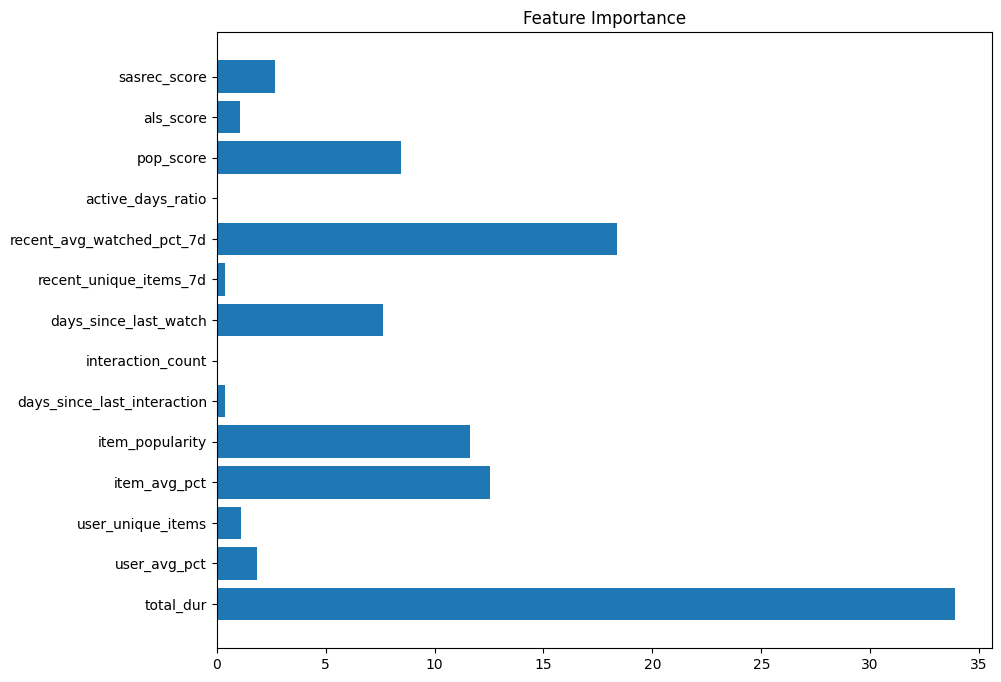

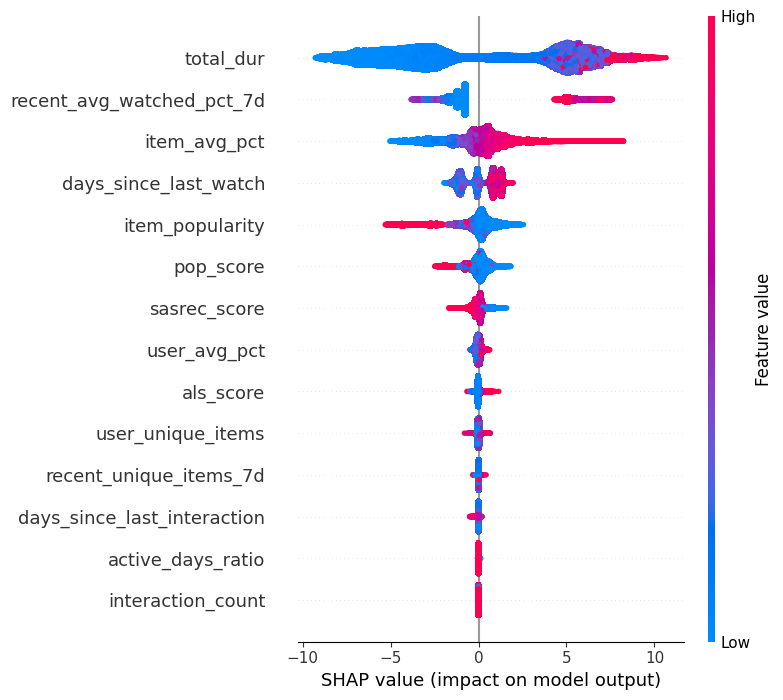

In [64]:
# Важность признаков
feature_importance = ranker.get_feature_importance(type="PredictionValuesChange")
plt.figure(figsize=(10, 8))
plt.barh(final_val.columns.drop(["user_id", "item_id", "last_watch_dt", "target"]), feature_importance)
plt.title("Feature Importance")
plt.show()

# SHAP значения
explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(train_pool)

# Визуализация SHAP-значений
shap.summary_plot(shap_values, train_pool.get_features(), feature_names=train_pool.get_feature_names())

**Вывод:** новые признаки (recent_avg_watched_pct_7d и item_avg_pct - хорошо улучшают предсказания), дата ликов нет. Из добавленных признако от моделей прервого уровня - наибольший вклад дает - als_score. По идеи, от моделей первого уровня должен быть наибольший вклад, но это не так, следовательно, можно сделать вывод, что они не дообучились.


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [67]:
# YOUR CODE HERE

In [68]:
#  Переобучение SASRec
def retrain_sasrec(full_data, seq_len=10, emb_dim=64, num_heads=2, num_layers=2, epochs=5):
    # 1. Предобработка данных
    user_history_full = preprocess_data(full_data, seq_len)
    
    # 2. Создаем новые словари
    user_map = {uid: i for i, uid in enumerate(full_data["user_id"].unique())}
    item_map = {iid: i for i, iid in enumerate(full_data["item_id"].unique())}
    num_users, num_items = len(user_map), len(item_map)
    
    # 3. Инициализация датасета и лоадера
    full_dataset = SASRecDataset(
        user_history=user_history_full,
        user_map=user_map,
        item_map=item_map,
        seq_len=seq_len
    )
    full_loader = DataLoader(full_dataset, batch_size=512, shuffle=True)
    
    # 4. Инициализация модели
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SASRec(
        num_users=num_users,
        num_items=num_items,
        emb_dim=emb_dim,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)
    
    # 5. Обучение
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, sequences, durations, percentages, targets in full_loader:
            users = users.to(device)
            sequences = sequences.to(device)
            durations = durations.to(device)
            percentages = percentages.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            preds = model(users, sequences, durations, percentages)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(full_loader):.4f}")
    
    # Сохраняем необходимые артефакты
    model.user_map = user_map
    model.item_map = item_map
    model.num_items = num_items
    
    return model

In [75]:
# Рекомендации (из 1 задания)
N = 50
def recommend_sasrec(user_id, k=N): 
    try:
        # Fallback для новых пользователей
        if user_id not in user_map:
            return pop_model.recommend(user_id, k) if hasattr(pop_model, 'recommend') else []
        
        # Получаем историю пользователя
        user_seq = user_history_train.get(user_id, [])[-SEQ_LEN:]
        seen_items = set(i[0] for i in user_seq)
        
        # Подготовка входных данных
        items = [item_map.get(i[0], 0) for i in user_seq]
        pad_len = SEQ_LEN - len(items)
        items_padded = [0] * pad_len + items
        durs_padded = [i[1] for i in user_seq] + [0.0] * pad_len
        pcts_padded = [i[2] for i in user_seq] + [0.0] * pad_len
        
        # Создаем тензоры
        user_tensor = torch.tensor([user_map[user_id]]).to(device)
        items_tensor = torch.tensor([items_padded]).to(device)
        durs_tensor = torch.tensor([durs_padded], dtype=torch.float).to(device)
        pcts_tensor = torch.tensor([pcts_padded], dtype=torch.float).to(device)
        
        # Получаем предсказания
        with torch.no_grad():
            scores = model_SASRec(user_tensor, items_tensor, durs_tensor, pcts_tensor)
            scores = scores.squeeze().cpu().numpy()
        
        # Формируем валидные рекомендации
        valid_items = list(item_map.keys())
        valid_scores = []
        for idx, score in enumerate(scores):
            if idx < len(valid_items):  # Защита от выхода за границы
                item_id = valid_items[idx]
                if item_id not in seen_items:
                    valid_scores.append((item_id, score))
        
        # Сортируем и выбираем топ-K
        valid_scores.sort(key=lambda x: -x[1])
        recommendations = [item_id for item_id, _ in valid_scores[:k]]
        
        # Добавляем fallback из популярных
        if len(recommendations) < k:
            fallback = pop_model.recommend(user_id, k - len(recommendations))
            recommendations += [x for x in fallback if x not in recommendations]
        
        return recommendations[:k]
    
    except Exception as e:
        print(f"SASRec error for user {user_id}: {str(e)}")
        return []

In [61]:
# Загрузка данных
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [62]:
# Преобразуем дату
train["last_watch_dt"] = pd.to_datetime(train["last_watch_dt"])
test["last_watch_dt"] = pd.to_datetime(test["last_watch_dt"])

In [63]:
# 1. Обучение моделей первого уровня на всех данных
# Объединяем train и test данные
full_data = pd.concat([train, test], ignore_index=True)

In [64]:
full_data.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


##### Переобучаем модели

In [37]:
pop_model = PopularityModel(full_data)

In [38]:
als_model = ALSModel(full_data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [76]:
# Переобучаем модели
model_SASRec = retrain_sasrec(full_data)

C:\Users\krugd\AppData\Local\Temp\ipykernel_36076\537746743.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_history = df.groupby("user_id").apply(
c:\Users\krugd\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/5 | Loss: 7.2091
Epoch 2/5 | Loss: 7.1119
Epoch 3/5 | Loss: 7.0245
Epoch 4/5 | Loss: 6.9078
Epoch 5/5 | Loss: 6.8928


In [74]:
# Сохраним веса если вдруг дропнется ядро
torch.save({
    "model_state_dict": model_SASRec.state_dict(),
    "user_map": model_SASRec.user_map,
    "item_map": model_SASRec.item_map},
    "SASRec_full_checkpoint.pth")

In [ ]:
# 2. Генерация кандидатов
N = 50
users = full_data['user_id'].unique()

candidates = {}
for user in tqdm(users, desc="Generating candidates"):
    try:
        # Получаем рекомендации от моделей
        pop_recs = pop_model.recommend(user, N) if hasattr(pop_model, 'recommend') else []
        als_recs = als_model.recommend(user, N) if hasattr(als_model, 'recommend') else []
        sas_recs = recommend_sasrec(user, N)
        
        # Приводим к спискам и фильтруем
        pop_recs = list(pop_recs) if isinstance(pop_recs, (list, np.ndarray)) else []
        als_recs = list(als_recs) if isinstance(als_recs, (list, np.ndarray)) else []
        sas_recs = list(sas_recs) if isinstance(sas_recs, (list, np.ndarray)) else []
        
        # Объединяем и удаляем дубли
        all_recs = list(set([x for x in pop_recs + als_recs + sas_recs if isinstance(x, (int, str))]))
        
    except Exception as e:
        print(f"Error for user {user}: {str(e)}")
        all_recs = []
    
    candidates[user] = all_recs

Generating candidates:   0%|          | 35/962151 [00:00<1:34:22, 169.92it/s]

SASRec error for user 310745: name 'device' is not defined
SASRec error for user 952323: name 'device' is not defined
SASRec error for user 889459: name 'device' is not defined
SASRec error for user 854016: name 'device' is not defined
SASRec error for user 307257: name 'device' is not defined
SASRec error for user 372891: name 'device' is not defined
SASRec error for user 443979: name 'device' is not defined
SASRec error for user 20758: name 'device' is not defined
SASRec error for user 258123: name 'device' is not defined
SASRec error for user 537398: name 'device' is not defined
SASRec error for user 408529: name 'device' is not defined
SASRec error for user 960602: name 'device' is not defined
SASRec error for user 19673: name 'device' is not defined
SASRec error for user 800566: name 'device' is not defined
SASRec error for user 713914: name 'device' is not defined
SASRec error for user 382278: name 'device' is not defined
SASRec error for user 492409: name 'device' is not defined

Generating candidates:   0%|          | 53/962151 [00:00<1:32:47, 172.82it/s]

SASRec error for user 514211: name 'device' is not defined
SASRec error for user 30173: name 'device' is not defined
SASRec error for user 333338: name 'device' is not defined
SASRec error for user 500755: name 'device' is not defined
SASRec error for user 944361: name 'device' is not defined
SASRec error for user 325370: name 'device' is not defined
SASRec error for user 1070345: name 'device' is not defined
SASRec error for user 1074497: name 'device' is not defined
SASRec error for user 820031: name 'device' is not defined
SASRec error for user 941887: name 'device' is not defined
SASRec error for user 615659: name 'device' is not defined
SASRec error for user 420169: name 'device' is not defined
SASRec error for user 459455: name 'device' is not defined
SASRec error for user 918052: name 'device' is not defined
SASRec error for user 984984: name 'device' is not defined
SASRec error for user 566604: name 'device' is not defined
SASRec error for user 728637: name 'device' is not defi

Generating candidates:   0%|          | 89/962151 [00:00<1:34:56, 168.88it/s]

SASRec error for user 238974: name 'device' is not defined
SASRec error for user 1087264: name 'device' is not defined
SASRec error for user 171945: name 'device' is not defined
SASRec error for user 115728: name 'device' is not defined
SASRec error for user 708946: name 'device' is not defined
SASRec error for user 936583: name 'device' is not defined
SASRec error for user 928971: name 'device' is not defined
SASRec error for user 41587: name 'device' is not defined
SASRec error for user 35781: name 'device' is not defined
SASRec error for user 807447: name 'device' is not defined
SASRec error for user 802584: name 'device' is not defined
SASRec error for user 777143: name 'device' is not defined
SASRec error for user 473049: name 'device' is not defined
SASRec error for user 248558: name 'device' is not defined
SASRec error for user 1045301: name 'device' is not defined
SASRec error for user 936702: name 'device' is not defined
SASRec error for user 754626: name 'device' is not defin

Generating candidates:   0%|          | 125/962151 [00:00<1:32:42, 172.94it/s]

SASRec error for user 176976: name 'device' is not defined
SASRec error for user 307825: name 'device' is not defined
SASRec error for user 552683: name 'device' is not defined
SASRec error for user 671253: name 'device' is not defined
SASRec error for user 795134: name 'device' is not defined
SASRec error for user 598447: name 'device' is not defined
SASRec error for user 617789: name 'device' is not defined
SASRec error for user 970496: name 'device' is not defined
SASRec error for user 320419: name 'device' is not defined
SASRec error for user 186096: name 'device' is not defined
SASRec error for user 973203: name 'device' is not defined
SASRec error for user 908568: name 'device' is not defined
SASRec error for user 56792: name 'device' is not defined
SASRec error for user 932771: name 'device' is not defined
SASRec error for user 259567: name 'device' is not defined
SASRec error for user 1079637: name 'device' is not defined
SASRec error for user 353275: name 'device' is not defin

Generating candidates:   0%|          | 161/962151 [00:00<1:32:57, 172.46it/s]

SASRec error for user 995325: name 'device' is not defined
SASRec error for user 718937: name 'device' is not defined
SASRec error for user 106215: name 'device' is not defined
SASRec error for user 531775: name 'device' is not defined
SASRec error for user 2968: name 'device' is not defined
SASRec error for user 497465: name 'device' is not defined
SASRec error for user 612182: name 'device' is not defined
SASRec error for user 383409: name 'device' is not defined
SASRec error for user 226326: name 'device' is not defined
SASRec error for user 563738: name 'device' is not defined
SASRec error for user 343993: name 'device' is not defined
SASRec error for user 739554: name 'device' is not defined
SASRec error for user 393744: name 'device' is not defined
SASRec error for user 763064: name 'device' is not defined
SASRec error for user 820230: name 'device' is not defined
SASRec error for user 61695: name 'device' is not defined
SASRec error for user 715987: name 'device' is not defined


Generating candidates:   0%|          | 197/962151 [00:01<1:34:34, 169.51it/s]

SASRec error for user 417118: name 'device' is not defined
SASRec error for user 6463: name 'device' is not defined
SASRec error for user 382752: name 'device' is not defined
SASRec error for user 301282: name 'device' is not defined
SASRec error for user 880175: name 'device' is not defined
SASRec error for user 921680: name 'device' is not defined
SASRec error for user 217603: name 'device' is not defined
SASRec error for user 550724: name 'device' is not defined
SASRec error for user 680569: name 'device' is not defined
SASRec error for user 901335: name 'device' is not defined
SASRec error for user 849801: name 'device' is not defined
SASRec error for user 558517: name 'device' is not defined
SASRec error for user 937491: name 'device' is not defined
SASRec error for user 740028: name 'device' is not defined
SASRec error for user 73709: name 'device' is not defined
SASRec error for user 526520: name 'device' is not defined
SASRec error for user 78985: name 'device' is not defined
S

Generating candidates:   0%|          | 231/962151 [00:01<1:35:30, 167.85it/s]

SASRec error for user 1016969: name 'device' is not defined
SASRec error for user 313421: name 'device' is not defined
SASRec error for user 804750: name 'device' is not defined
SASRec error for user 801499: name 'device' is not defined
SASRec error for user 118094: name 'device' is not defined
SASRec error for user 796395: name 'device' is not defined
SASRec error for user 769945: name 'device' is not defined
SASRec error for user 242968: name 'device' is not defined
SASRec error for user 231405: name 'device' is not defined
SASRec error for user 9680: name 'device' is not defined
SASRec error for user 711738: name 'device' is not defined
SASRec error for user 650377: name 'device' is not defined
SASRec error for user 888127: name 'device' is not defined
SASRec error for user 752126: name 'device' is not defined
SASRec error for user 669627: name 'device' is not defined
SASRec error for user 452196: name 'device' is not defined
SASRec error for user 878386: name 'device' is not define

Generating candidates:   0%|          | 265/962151 [00:01<1:38:04, 163.46it/s]

SASRec error for user 936830: name 'device' is not defined
SASRec error for user 195195: name 'device' is not defined
SASRec error for user 628231: name 'device' is not defined
SASRec error for user 915819: name 'device' is not defined
SASRec error for user 134806: name 'device' is not defined
SASRec error for user 937676: name 'device' is not defined
SASRec error for user 24411: name 'device' is not defined
SASRec error for user 712559: name 'device' is not defined
SASRec error for user 332696: name 'device' is not defined
SASRec error for user 1030472: name 'device' is not defined
SASRec error for user 86952: name 'device' is not defined
SASRec error for user 991609: name 'device' is not defined
SASRec error for user 255682: name 'device' is not defined
SASRec error for user 289672: name 'device' is not defined
SASRec error for user 855000: name 'device' is not defined
SASRec error for user 256100: name 'device' is not defined
SASRec error for user 157778: name 'device' is not define

Generating candidates:   0%|          | 299/962151 [00:01<1:38:10, 163.30it/s]

SASRec error for user 275759: name 'device' is not defined
SASRec error for user 829890: name 'device' is not defined
SASRec error for user 383446: name 'device' is not defined
SASRec error for user 731265: name 'device' is not defined
SASRec error for user 377498: name 'device' is not defined
SASRec error for user 151758: name 'device' is not defined
SASRec error for user 78509: name 'device' is not defined
SASRec error for user 472938: name 'device' is not defined
SASRec error for user 861245: name 'device' is not defined
SASRec error for user 618673: name 'device' is not defined
SASRec error for user 737226: name 'device' is not defined
SASRec error for user 526367: name 'device' is not defined
SASRec error for user 258774: name 'device' is not defined
SASRec error for user 536368: name 'device' is not defined
SASRec error for user 320234: name 'device' is not defined
SASRec error for user 243754: name 'device' is not defined
SASRec error for user 235491: name 'device' is not define

Generating candidates:   0%|          | 333/962151 [00:01<1:37:28, 164.44it/s]

SASRec error for user 532736: name 'device' is not defined
SASRec error for user 303790: name 'device' is not defined
SASRec error for user 945735: name 'device' is not defined
SASRec error for user 241403: name 'device' is not defined
SASRec error for user 522752: name 'device' is not defined
SASRec error for user 958006: name 'device' is not defined
SASRec error for user 710882: name 'device' is not defined
SASRec error for user 113877: name 'device' is not defined
SASRec error for user 274923: name 'device' is not defined
SASRec error for user 698663: name 'device' is not defined
SASRec error for user 879708: name 'device' is not defined
SASRec error for user 945924: name 'device' is not defined
SASRec error for user 344371: name 'device' is not defined
SASRec error for user 541662: name 'device' is not defined
SASRec error for user 421277: name 'device' is not defined
SASRec error for user 710817: name 'device' is not defined
SASRec error for user 1048593: name 'device' is not defi

Generating candidates:   0%|          | 367/962151 [00:02<1:36:39, 165.83it/s]

SASRec error for user 607977: name 'device' is not defined
SASRec error for user 617024: name 'device' is not defined
SASRec error for user 865934: name 'device' is not defined
SASRec error for user 935978: name 'device' is not defined
SASRec error for user 966938: name 'device' is not defined
SASRec error for user 334479: name 'device' is not defined
SASRec error for user 239701: name 'device' is not defined
SASRec error for user 231888: name 'device' is not defined
SASRec error for user 704819: name 'device' is not defined
SASRec error for user 67443: name 'device' is not defined
SASRec error for user 424663: name 'device' is not defined
SASRec error for user 166001: name 'device' is not defined
SASRec error for user 516411: name 'device' is not defined
SASRec error for user 780569: name 'device' is not defined
SASRec error for user 946555: name 'device' is not defined
SASRec error for user 684836: name 'device' is not defined
SASRec error for user 865041: name 'device' is not define

Generating candidates:   0%|          | 401/962151 [00:02<1:36:10, 166.67it/s]

SASRec error for user 202590: name 'device' is not defined
SASRec error for user 823979: name 'device' is not defined
SASRec error for user 1047878: name 'device' is not defined
SASRec error for user 823641: name 'device' is not defined
SASRec error for user 171627: name 'device' is not defined
SASRec error for user 422360: name 'device' is not defined
SASRec error for user 1007883: name 'device' is not defined
SASRec error for user 330435: name 'device' is not defined
SASRec error for user 30405: name 'device' is not defined
SASRec error for user 1055580: name 'device' is not defined
SASRec error for user 211980: name 'device' is not defined
SASRec error for user 261888: name 'device' is not defined
SASRec error for user 191829: name 'device' is not defined
SASRec error for user 414679: name 'device' is not defined
SASRec error for user 523315: name 'device' is not defined
SASRec error for user 68556: name 'device' is not defined
SASRec error for user 206963: name 'device' is not defi

Generating candidates:   0%|          | 435/962151 [00:02<1:38:28, 162.76it/s]

SASRec error for user 346469: name 'device' is not defined
SASRec error for user 643374: name 'device' is not defined
SASRec error for user 357590: name 'device' is not defined
SASRec error for user 320692: name 'device' is not defined
SASRec error for user 767457: name 'device' is not defined
SASRec error for user 277376: name 'device' is not defined
SASRec error for user 415936: name 'device' is not defined
SASRec error for user 275610: name 'device' is not defined
SASRec error for user 677326: name 'device' is not defined
SASRec error for user 641355: name 'device' is not defined
SASRec error for user 548195: name 'device' is not defined
SASRec error for user 939532: name 'device' is not defined
SASRec error for user 1009455: name 'device' is not defined
SASRec error for user 7212: name 'device' is not defined
SASRec error for user 677669: name 'device' is not defined
SASRec error for user 821094: name 'device' is not defined
SASRec error for user 9780: name 'device' is not defined


Generating candidates:   0%|          | 469/962151 [00:02<1:37:20, 164.65it/s]

SASRec error for user 200467: name 'device' is not defined
SASRec error for user 103443: name 'device' is not defined
SASRec error for user 858100: name 'device' is not defined
SASRec error for user 301624: name 'device' is not defined
SASRec error for user 216814: name 'device' is not defined
SASRec error for user 792031: name 'device' is not defined
SASRec error for user 310113: name 'device' is not defined
SASRec error for user 318269: name 'device' is not defined
SASRec error for user 422561: name 'device' is not defined
SASRec error for user 503844: name 'device' is not defined
SASRec error for user 976690: name 'device' is not defined
SASRec error for user 951133: name 'device' is not defined
SASRec error for user 1073753: name 'device' is not defined
SASRec error for user 215081: name 'device' is not defined
SASRec error for user 837876: name 'device' is not defined
SASRec error for user 165173: name 'device' is not defined
SASRec error for user 453357: name 'device' is not defi

Generating candidates:   0%|          | 503/962151 [00:03<1:36:30, 166.08it/s]

SASRec error for user 4871: name 'device' is not defined
SASRec error for user 328297: name 'device' is not defined
SASRec error for user 507311: name 'device' is not defined
SASRec error for user 146927: name 'device' is not defined
SASRec error for user 1051398: name 'device' is not defined
SASRec error for user 799869: name 'device' is not defined
SASRec error for user 578790: name 'device' is not defined
SASRec error for user 774120: name 'device' is not defined
SASRec error for user 30824: name 'device' is not defined
SASRec error for user 352986: name 'device' is not defined
SASRec error for user 717843: name 'device' is not defined
SASRec error for user 1056692: name 'device' is not defined
SASRec error for user 6407: name 'device' is not defined
SASRec error for user 554256: name 'device' is not defined
SASRec error for user 81298: name 'device' is not defined
SASRec error for user 730122: name 'device' is not defined
SASRec error for user 242051: name 'device' is not defined
S

Generating candidates:   0%|          | 534/962151 [00:03<1:35:52, 167.18it/s]


SASRec error for user 310836: name 'device' is not defined
SASRec error for user 591091: name 'device' is not defined
SASRec error for user 252549: name 'device' is not defined
SASRec error for user 575093: name 'device' is not defined
SASRec error for user 945011: name 'device' is not defined
SASRec error for user 631766: name 'device' is not defined
SASRec error for user 142785: name 'device' is not defined
SASRec error for user 660051: name 'device' is not defined
SASRec error for user 287588: name 'device' is not defined
SASRec error for user 789500: name 'device' is not defined
SASRec error for user 974944: name 'device' is not defined
SASRec error for user 931946: name 'device' is not defined
SASRec error for user 182901: name 'device' is not defined


KeyboardInterrupt: 

In [ ]:
with open("candidates.pkl", "wb") as f:
    pickle.dump(candidates, f)

In [79]:
with open("candidates.pkl", "rb") as f:
    candidates = pickle.load(f)

In [87]:
candidates

{310745: [9728,
  512,
  11778,
  4740,
  1287,
  9996,
  12173,
  142,
  4495,
  16270,
  657,
  7571,
  10772,
  14741,
  3734,
  7829,
  6809,
  5658,
  1819,
  16166,
  13865,
  11310,
  1844,
  12981,
  4151,
  8636,
  5693,
  7102,
  15297,
  12995,
  10440,
  3784,
  7626,
  9169,
  849,
  4436,
  12501,
  13018,
  14431,
  3935,
  2657,
  11237,
  15464,
  4457,
  14317,
  3182,
  14703,
  7793,
  7417,
  14461],
 952323: [9728,
  512,
  11778,
  4740,
  1287,
  9996,
  12173,
  142,
  4495,
  16270,
  657,
  7571,
  10772,
  14741,
  3734,
  7829,
  6809,
  5658,
  1819,
  16166,
  13865,
  11310,
  1844,
  12981,
  4151,
  8636,
  5693,
  7102,
  15297,
  12995,
  10440,
  3784,
  7626,
  9169,
  849,
  4436,
  12501,
  13018,
  14431,
  3935,
  2657,
  11237,
  15464,
  4457,
  14317,
  3182,
  14703,
  7793,
  7417,
  14461],
 889459: [9728,
  512,
  11778,
  4740,
  1287,
  9996,
  12173,
  142,
  4495,
  16270,
  657,
  7571,
  10772,
  14741,
  3734,
  7829,
  6809,
  56

##### Склеим юзеров с рекомендованными айтемами

In [167]:
candidates_df = pd.DataFrame({
    'user_id': list(candidates.keys()),
    'recommended_items': list(candidates.values())
})

# Для каждого пользователя в full_data оставляем только первую строку
unique_users_df = full_data.drop_duplicates(subset=['user_id'], keep='first')

# Объединяем с рекомендациями
recommendations_df = unique_users_df.merge(candidates_df, on='user_id', how='left')

# Заполняем пропуски в recommended_items пустыми списками
recommendations_df['recommended_items'] = recommendations_df['recommended_items'].apply(lambda x: x if isinstance(x, list) else [])

In [168]:
recommendations_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,recommended_items
0,310745,13373,2021-03-13,4485,98.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14..."
1,952323,15997,2021-03-13,7507,100.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14..."
2,889459,11460,2021-03-13,60,0.0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14..."
3,854016,11237,2021-03-13,5381,98.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14..."
4,307257,9132,2021-03-13,5814,100.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14..."


In [80]:
# 3. Сбор скоров моделей
candidate_scores = []
for user, items in tqdm(candidates.items(), desc="Scoring candidates"):
    for item in items:
        scores = {
            'user_id': user,
            'item_id': item,
            'pop_score': pop_model.predict(user, item),
            'als_score': als_model.predict(user, item),
            'sasrec_score': recommend_sasrec_2(user, item)
        }
        candidate_scores.append(scores)

candidates_df = pd.DataFrame(candidate_scores)

Scoring candidates: 100%|██████████| 962151/962151 [15:18:39<00:00, 17.46it/s]   


In [81]:
candidates_df.to_pickle("candidates_df.pkl")

In [169]:
with open("candidates_df.pkl", "rb") as f:
    candidates_df = pickle.load(f)

In [170]:
candidates_df

,user_id,item_id,pop_score,als_score,sasrec_score
0,310745,9728,74589,-2.383706e-04,3.996267
1,310745,512,4793,-4.659133e-04,1.824841
2,310745,11778,6453,-6.706125e-04,2.074486
3,310745,4740,12951,2.743430e-04,2.326252
4,310745,1287,5037,8.864162e-04,1.149161
...,...,...,...,...,...
48107545,100875,3182,7353,6.603167e-08,0.000000
48107546,100875,14703,7631,-2.137939e-07,0.000000
48107547,100875,7793,4908,-3.215402e-08,0.000000
48107548,100875,7417,10931,1.692533e-07,0.000000


In [127]:
# Группируем candidates_df и собираем скоры в списки
grouped_scores = candidates_df.groupby('user_id').agg({
    'item_id': list,
    'pop_score': list,
    'als_score': list,
    'sasrec_score': list
}).rename(columns={
    'item_id': 'scored_items',
    'pop_score': 'pop_scores',
    'als_score': 'als_scores',
    'sasrec_score': 'sasrec_scores'
}).reset_index()

In [171]:
grouped_scores.head()

,user_id,scored_items,pop_scores,als_scores,sasrec_scores
0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.00014315109001472592, 9.816187684918987e-0...","[4.983710289001465, 3.5343010425567627, 2.4883..."
1,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-6.850837962701917e-05, 0.0001496453769505024...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.0032424197997897863, -0.001759504200890660...","[3.9913599491119385, 2.1758196353912354, 1.217..."
3,3,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[0.999558687210083, 0.022762112319469452, -0.0...","[4.484394073486328, 1.872215747833252, 2.30596..."
4,4,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-8.532848005415872e-05, -3.5447847039904445e-...","[4.05687141418457, 1.46085786819458, 1.9284729..."


In [172]:
# Объединяем с recommendations_df
recommendations_df = recommendations_df.merge(
    grouped_scores,
    on='user_id',
    how='left'
)

In [173]:
recommendations_df

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,recommended_items,scored_items,pop_scores,als_scores,sasrec_scores
0,310745,13373,2021-03-13,4485,98.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.00023837057233322412, -0.00046591329737566...","[3.996267080307007, 1.824841022491455, 2.07448..."
1,952323,15997,2021-03-13,7507,100.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.003436155617237091, -0.0019623758271336555...","[4.419181823730469, 1.66441011428833, 2.027665..."
2,889459,11460,2021-03-13,60,0.0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.0017548040486872196, -0.022521033883094788...","[4.0313801765441895, 2.430772542953491, 1.6467..."
3,854016,11237,2021-03-13,5381,98.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.0009570267284289002, -0.000760711729526519...","[4.125551223754883, 0.9675512909889221, 1.6596..."
4,307257,9132,2021-03-13,5814,100.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.0016210610046982765, -0.001701373839750886...","[4.315196990966797, 1.6481974124908447, 1.4814..."
...,...,...,...,...,...,...,...,...,...,...,...
962146,1011483,15297,2021-08-22,10847,50.0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-1.126143160945503e-06, 1.5061050362419337e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
962147,828764,4495,2021-08-22,131,3.0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[5.431255800658619e-08, 8.667979045640095e-07,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
962148,903387,3404,2021-08-22,835,13.0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[6.586546629286372e-13, 3.361792723539925e-13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
962149,808301,10440,2021-08-22,12728,50.0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-2.9855328875783016e-08, -1.9522133243299322e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Сохранение в CSV
recommendations_df.to_csv('recommendations.csv', index=False)

In [174]:
def generate_features(recommendations_df, date, n_days_short=7, n_days_long=14):
    """
    Генерирует все 10 признаков для заданного DataFrame на указанную дату
    """
    # Копируем исходный DataFrame, чтобы не изменять оригинал
    df = recommendations_df.copy()
    
    # Преобразуем даты и фильтруем данные до указанной даты
    df['last_watch_dt'] = pd.to_datetime(df['last_watch_dt'])
    filtered_df = df[df['last_watch_dt'] < date]
    
    # 1. Средний процент просмотра пользователя
    user_avg_pct = filtered_df.groupby("user_id")["watched_pct"].mean().rename("user_avg_pct")
    
    # 2. Количество уникальных айтемов пользователя
    user_unique_items = filtered_df.groupby("user_id")["item_id"].nunique().rename("user_unique_items")
    
    # 3. Средний процент просмотра айтема
    item_avg_pct = filtered_df.groupby("item_id")["watched_pct"].mean().rename("item_avg_pct")
    
    # 4. Популярность айтема (количество уникальных пользователей)
    item_popularity = filtered_df.groupby("item_id")["user_id"].nunique().rename("item_popularity")
    
    # 5. Дней с последнего просмотра пользователем
    last_interaction_dates = filtered_df.groupby("user_id")["last_watch_dt"].max()
    days_since_last_interaction = (date - last_interaction_dates).dt.days.rename("days_since_last_interaction")
    max_days = (date - df['last_watch_dt'].min()).days
    days_since_last_interaction = days_since_last_interaction.fillna(max_days)
    
    # 6. Количество взаимодействий для пары (user_id, item_id)
    interaction_count = filtered_df.groupby(["user_id", "item_id"]).size().rename("interaction_count")
    
    # 7. Количество дней с последнего просмотра айтема пользователем
    last_watch_dates = filtered_df.groupby(["user_id", "item_id"])["last_watch_dt"].max()
    days_since_last_watch = (date - last_watch_dates).dt.days.rename("days_since_last_watch")
    
    # Фильтруем данные за последние N дней (для краткосрочных признаков)
    start_date_short = date - pd.Timedelta(days=n_days_short)
    recent_df_short = df[(df["last_watch_dt"] >= start_date_short) & (df["last_watch_dt"] <= date)]
    
    # 8. Количество уникальных айтемов пользователя за последние N дней
    recent_unique_items = recent_df_short.groupby("user_id")["item_id"].nunique().rename(f"recent_unique_items_{n_days_short}d")
    
    # 9. Средний процент просмотра айтема пользователем за последние N дней
    recent_avg_watched_pct = recent_df_short.groupby(["user_id", "item_id"])["watched_pct"].mean().rename(f"recent_avg_watched_pct_{n_days_short}d")
    
    # Фильтруем данные за последние N дней (для долгосрочных признаков)
    start_date_long = date - pd.Timedelta(days=n_days_long)
    recent_df_long = df[(df["last_watch_dt"] >= start_date_long) & (df["last_watch_dt"] <= date)]
    
    # 10. Доля дней с взаимодействиями за последние N дней
    active_days = recent_df_long.groupby(["user_id", "item_id"])["last_watch_dt"].nunique().rename("active_days")
    active_days_ratio = (active_days / n_days_long).rename("active_days_ratio")
    
    # Создаем результирующий DataFrame
    result_df = recommendations_df[['user_id', 'item_id']].copy()
    
    # Объединяем все признаки
    result_df = result_df.merge(user_avg_pct, on="user_id", how="left")
    result_df = result_df.merge(user_unique_items, on="user_id", how="left")
    result_df = result_df.merge(item_avg_pct, on="item_id", how="left")
    result_df = result_df.merge(item_popularity, on="item_id", how="left")
    result_df = result_df.merge(days_since_last_interaction, on="user_id", how="left")
    result_df = result_df.merge(interaction_count, on=["user_id", "item_id"], how="left")
    result_df = result_df.merge(days_since_last_watch, on=["user_id", "item_id"], how="left")
    result_df = result_df.merge(recent_unique_items, on="user_id", how="left")
    result_df = result_df.merge(recent_avg_watched_pct, on=["user_id", "item_id"], how="left")
    result_df = result_df.merge(active_days_ratio, on=["user_id", "item_id"], how="left")
    
    # Заполняем пропущенные значения
    fill_values = {
        "user_avg_pct": 0,
        "user_unique_items": 0,
        "item_avg_pct": 0,
        "item_popularity": 0,
        "interaction_count": 0,
        "days_since_last_watch": max_days,
        f"recent_unique_items_{n_days_short}d": 0,
        f"recent_avg_watched_pct_{n_days_short}d": 0,
        "active_days_ratio": 0
    }
    
    result_df = result_df.fillna(fill_values)
    
    return result_df

In [175]:
# Преобразование дат и определение временных промежутков
recommendations_df['last_watch_dt'] = pd.to_datetime(recommendations_df['last_watch_dt'])

recommendations_df_end = recommendations_df['last_watch_dt'].max()

# Генерация признаков
recommendations_df_features = generate_features(recommendations_df, recommendations_df_end)

In [176]:
recommendations_df_features

,user_id,item_id,user_avg_pct,user_unique_items,item_avg_pct,item_popularity,days_since_last_interaction,interaction_count,days_since_last_watch,recent_unique_items_7d,recent_avg_watched_pct_7d,active_days_ratio
0,310745,13373,98.0,1.0,52.098039,51.0,162.0,1.0,162.0,0.0,0.0,0.000000
1,952323,15997,100.0,1.0,44.903830,1227.0,162.0,1.0,162.0,0.0,0.0,0.000000
2,889459,11460,0.0,1.0,10.264706,170.0,162.0,1.0,162.0,0.0,0.0,0.000000
3,854016,11237,98.0,1.0,58.303832,9186.0,162.0,1.0,162.0,0.0,0.0,0.000000
4,307257,9132,100.0,1.0,47.516484,455.0,162.0,1.0,162.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
962146,1011483,15297,0.0,0.0,43.211787,67157.0,NaN,0.0,162.0,1.0,50.0,0.071429
962147,828764,4495,0.0,0.0,34.775614,3543.0,NaN,0.0,162.0,1.0,3.0,0.071429
962148,903387,3404,0.0,0.0,41.820000,50.0,NaN,0.0,162.0,1.0,13.0,0.071429
962149,808301,10440,0.0,0.0,39.096534,85980.0,NaN,0.0,162.0,1.0,50.0,0.071429


In [177]:
features_columns = [
    'user_avg_pct', 'user_unique_items', 'item_avg_pct', 'item_popularity',
    'days_since_last_interaction', 'interaction_count', 'days_since_last_watch',
    'recent_unique_items_7d', 'recent_avg_watched_pct_7d', 'active_days_ratio'
]

# Добавляем признаки к исходному DataFrame по совпадающим user_id и item_id
df_final_cat = recommendations_df.merge(
    recommendations_df_features[['user_id', 'item_id'] + features_columns],
    on=['user_id', 'item_id'],
    how='left'
)

# Заполняем пропуски нулями
df_final_cat[features_columns] = df_final_cat[features_columns].fillna(0)

In [178]:
df_final_cat.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,recommended_items,scored_items,pop_scores,als_scores,...,user_avg_pct,user_unique_items,item_avg_pct,item_popularity,days_since_last_interaction,interaction_count,days_since_last_watch,recent_unique_items_7d,recent_avg_watched_pct_7d,active_days_ratio
0,310745,13373,2021-03-13,4485,98.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.00023837057233322412, -0.00046591329737566...",...,98.0,1.0,52.098039,51.0,162.0,1.0,162.0,0.0,0.0,0.0
1,952323,15997,2021-03-13,7507,100.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.003436155617237091, -0.0019623758271336555...",...,100.0,1.0,44.903830,1227.0,162.0,1.0,162.0,0.0,0.0,0.0
2,889459,11460,2021-03-13,60,0.0,0,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.0017548040486872196, -0.022521033883094788...",...,0.0,1.0,10.264706,170.0,162.0,1.0,162.0,0.0,0.0,0.0
3,854016,11237,2021-03-13,5381,98.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.0009570267284289002, -0.000760711729526519...",...,98.0,1.0,58.303832,9186.0,162.0,1.0,162.0,0.0,0.0,0.0
4,307257,9132,2021-03-13,5814,100.0,1,"[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[9728, 512, 11778, 4740, 1287, 9996, 12173, 14...","[74589, 4793, 6453, 12951, 5037, 8870, 7457, 2...","[-0.0016210610046982765, -0.001701373839750886...",...,100.0,1.0,47.516484,455.0,162.0,1.0,162.0,0.0,0.0,0.0


In [179]:
# Сохранение в CSV
df_final_cat.to_csv('df_final_cat.csv', index=False)

In [47]:
df_final_cat = pd.read_csv("df_final_cat.csv")

In [70]:
def get_top_k_recommendations(row, ranker, k=10):
    """Для одного пользователя выбирает топ-k айтемов по CatBoost"""
    # 1. Преобразуем строки с списками в настоящие списки
    if isinstance(row['recommended_items'], str):
        recommended_items = ast.literal_eval(row['recommended_items'])
        pop_scores = ast.literal_eval(row['pop_scores'])
        als_scores = ast.literal_eval(row['als_scores'])
        scored_items = ast.literal_eval(row['scored_items'])
    else:
        recommended_items = row['recommended_items']
        pop_scores = row['pop_scores']
        als_scores = row['als_scores']
        scored_items = row['scored_items']
    
    # 2. Создаем DataFrame с рекомендациями и скорами
    user_recs = pd.DataFrame({
        'item_id': recommended_items,
        'pop_score': pop_scores,
        'als_score': als_scores,
        'sasrec_score': scored_items
    })
    
    # 3. Добавляем пользовательские фичи
    user_features = {
        'total_dur': row['total_dur'],
        'user_avg_pct': row['user_avg_pct'],
        'user_unique_items': row['user_unique_items'],
        'item_avg_pct': row['item_avg_pct'],
        'item_popularity': row['item_popularity'],
        'days_since_last_interaction': row['days_since_last_interaction'],
        'interaction_count': row['interaction_count'],
        'days_since_last_watch': row['days_since_last_watch'],
        'recent_unique_items_7d': row['recent_unique_items_7d'],
        'recent_avg_watched_pct_7d': row['recent_avg_watched_pct_7d'],
        'active_days_ratio': row['active_days_ratio']
    }
    
    for feature, value in user_features.items():
        user_recs[feature] = value  
    
    # 4. Предсказание CatBoost
    features = user_recs.drop(columns=['item_id'])
    pool = Pool(
        data=features,
        group_id=[row['user_id']] * len(features)
    )
    user_recs['catboost_score'] = ranker.predict(pool)
    
    # 5. Возвращаем топ-K item_id
    return user_recs.nlargest(k, 'catboost_score')['item_id'].tolist()

In [71]:
tqdm.pandas()
df_final_cat['top_10_recommendations'] = df_final_cat.progress_apply(
    lambda x: get_top_k_recommendations(x, ranker, k=10),
    axis=1
)

100%|██████████| 962151/962151 [59:54<00:00, 267.66it/s]  


In [73]:
result = df_final_cat[['user_id', 'top_10_recommendations']].copy()

In [76]:
result.head()

,user_id,top_10_recommendations
0,310745,"[8636, 6809, 7571, 11237, 4740, 3734, 1844, 12..."
1,952323,"[4151, 15297, 4457, 7102, 8636, 16166, 7571, 1..."
2,889459,"[657, 14461, 512, 849, 7793, 12981, 10772, 128..."
3,854016,"[657, 11237, 849, 14461, 16270, 12501, 12173, ..."
4,307257,"[8636, 11237, 6809, 3734, 1844, 14431, 7417, 4..."


In [77]:
# Сохранение в CSV
result.to_csv('result.csv', index=False)

In [ ]:
result

,user_id,top_10_recommendations
0,310745,"[8636, 6809, 7571, 11237, 4740, 3734, 1844, 12..."
1,952323,"[4151, 15297, 4457, 7102, 8636, 16166, 7571, 1..."
2,889459,"[657, 14461, 512, 849, 7793, 12981, 10772, 128..."
3,854016,"[657, 11237, 849, 14461, 16270, 12501, 12173, ..."
4,307257,"[8636, 11237, 6809, 3734, 1844, 14431, 7417, 4..."
...,...,...
962146,1011483,"[12173, 12995, 7626, 4436, 9996, 11237, 4740, ..."
962147,828764,"[12501, 512, 1287, 849, 7793, 16270, 10772, 11..."
962148,903387,"[512, 1287, 16270, 657, 10772, 11310, 849, 144..."
962149,808301,"[8636, 12173, 7102, 16166, 9996, 4740, 1844, 4..."


##### 1. расчитаем: Diversity,  Intra-list Diversity (для одного пользователя), Coverage (покрытие каталога)

In [38]:
def calculate_diversity_full(df):
    """Вычисляет метрики diversity для всего датафрейма"""
    # 1. Считаем популярность айтемов
    all_items = [item for sublist in df['top_10_recommendations'] for item in sublist]
    item_counts = pd.Series(all_items).value_counts()
    item_popularity = item_counts.to_dict()
    total_items = len(item_popularity)
    
    # 2. Intra-list Diversitн
    intra_div = []
    batch_size = 100000  # Обрабатываем пользователей батчами для экономии памяти
    
    for i in tqdm(range(0, len(df), batch_size), desc="Intra-list Diversity"):
        batch = df.iloc[i:i+batch_size]
        for recs in batch['top_10_recommendations']:
            pops = [item_popularity[item] for item in recs]
            intra_div.append(np.std(pops))
    
    # 3. Inter-list Diversity (выборочный расчет)
    inter_div = []
    n_pairs = 2000 
    rec_lists = df['top_10_recommendations'].values
    
    for _ in tqdm(range(n_pairs), desc="Inter-list Diversity"):
        a, b = np.random.choice(rec_lists, 2, replace=False)
        intersection = len(set(a) & set(b))
        union = len(set(a) | set(b))
        inter_div.append(1 - intersection/union if union > 0 else 1)
    
    # 4. Coverage
    unique_items = set(all_items)
    coverage = len(unique_items) / total_items
    
    return {
        'intra_list_diversity': np.mean(intra_div),
        'inter_list_diversity': np.mean(inter_div),
        'coverage': coverage,
        'num_users': len(df),
        'num_items': total_items
    }

In [47]:
def visualize_full_metrics(metrics):
    """Визуализация для полного датасета"""
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics_data = [
        ('Intra-list Diversity', metrics['intra_list_diversity'], '#4E79A7'),
        ('Inter-list Diversity', metrics['inter_list_diversity'], '#F28E2B'),
        ('Catalog Coverage', metrics['coverage'], '#E15759')
    ]
    
    for i, (title, value, color) in enumerate(metrics_data):
        ax[i].bar(title, value, color=color)
        ax[i].set_title(title, fontsize=14, pad=20)
        ax[i].set_ylim(0, value*1.5 if i < 2 else 1)
        
        # Добавляем значение и пояснение
        ax[i].text(0, value/2, f"{value:.4f}\n±{value*0.05:.4f}", 
                  ha='center', va='center', fontsize=12)
        ax[i].grid(axis='y', alpha=0.3)
    
    plt.suptitle(
        f"Full Dataset Diversity Analysis",
        fontsize=16,
        y=1.05
    )

    plt.tight_layout()
    plt.show()

In [40]:
# Расчет метрик
full_metrics = calculate_diversity_full(result)

Inter-list Diversity: 100%|██████████| 2000/2000 [00:30<00:00, 64.72it/s]


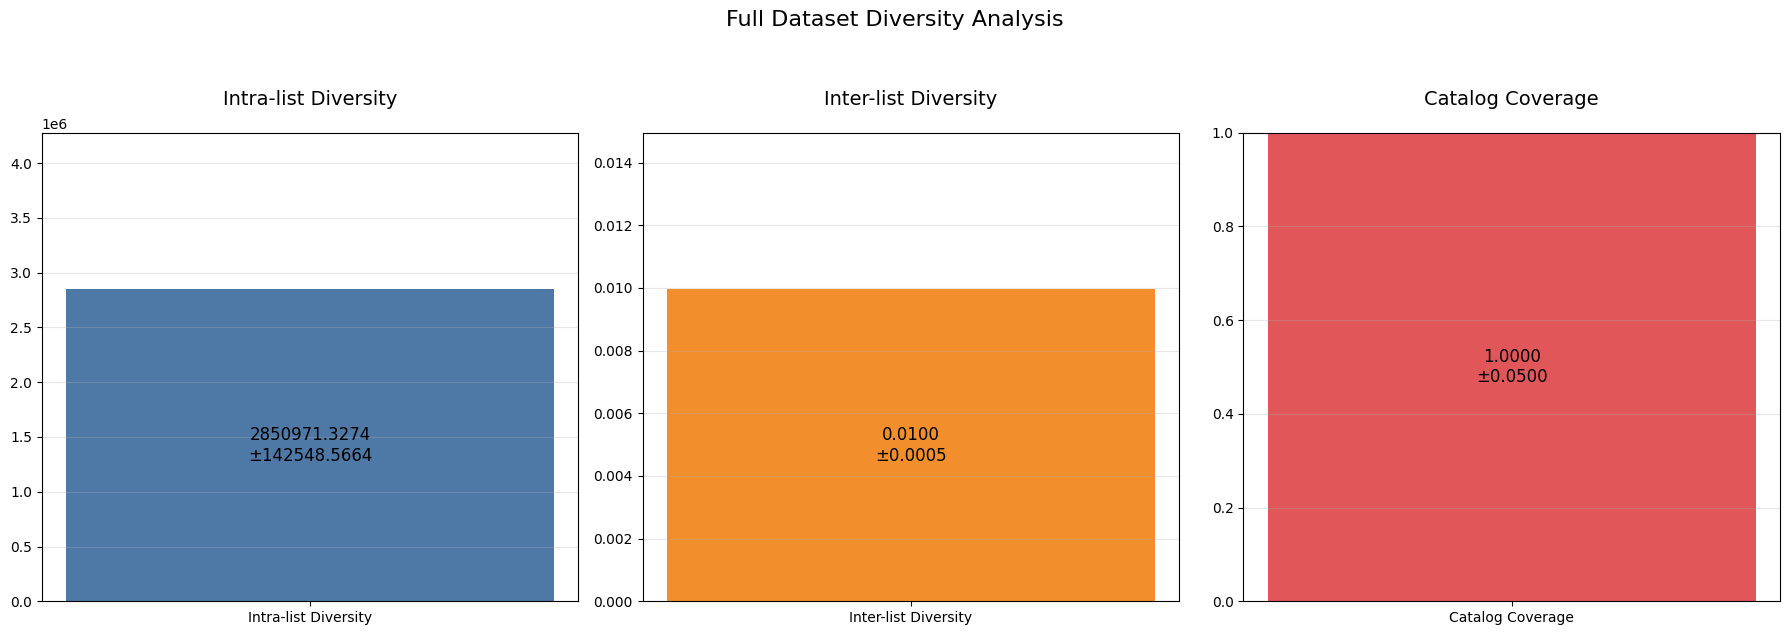

In [48]:
# Визуализация
visualize_full_metrics(full_metrics)

**Вывод**: проблемы:Inter-list Diversity: 0.01 ±0.0005, следовательно, очень низкое значение (близкое к 0) расстояния Jaccard, это означает, что рекомендации разных пользователей почти идентичны: 99% совпадения между списками разных пользователей (система рекомендует всем одно и то же). Думаю, эта связанно с плохо обученным Catboost и подобранными гипер параметрами. Catalog Coverage: 1 ±0.05, что это значит: полное покрытие каталога (100%), т.е. все существующие айтемы были рекомендованы.